# Tech Career Growth & Recommendation Forecaster — Final Notebook
**Author:** Jennifer Clark  
**Date:** 11-08-2025  

This project predicts future trends in tech jobs, identifies emerging roles, and recommends upskilling paths using BLS 2023–2033, WEF 2025, and Kaggle job/skills datasets.

---

## Table of Contents

| Section | Title | Description |
|:--|:--|:--|
| [00. Setup & Imports](#s00) | Initialize environment, imports, and helper modules. |
| [01. Problem Statement](#s01) | Motivation, goals, and research questions. |
| [02. Data Sources & Loading](#s02) | Load and preview datasets (BLS, WEF, Kaggle). |
| [03. Feature Engineering](#s03) | Clean, merge, select features, define targets. |
| [04. Classification: Emerging vs. Not](#s04) | Predict emerging roles; evaluate metrics & confusion matrix. |
| [05. Regression: Growth Rate Forecast](#s05) | Predict growth rates; evaluate RMSE/MAE/R². |
| [06. Findings & Recommendations](#s06) | Key insights and up to 3 client recommendations. |
| [07. Export Final Artifacts](#s07) | Save Model_Metrics (CSV/TXT/JSON). |
| [08. Appendix](#s08) | Data dictionary, visuals, feature list, limitations. |

Click a section above to jump directly.



<a id="s00"></a>
## 00. Setup & Imports
Initialize environment, install any missing packages, and import helper modules.


In [88]:
import os, json, textwrap, pathlib, datetime, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, log_loss, confusion_matrix, brier_score_loss,
    r2_score, mean_squared_error, mean_absolute_error, ConfusionMatrixDisplay
)

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 150)

SEED = 42
np.random.seed(SEED)

print("Imports ready (seed set to 42)")


Imports ready (seed set to 42)


In [92]:
# create folders
os.makedirs("data/raw", exist_ok=True)
os.makedirs("outputs", exist_ok=True)
print("Folders ready: data/raw/, outputs/")


Folders ready: data/raw/, outputs/


In [94]:
# Safe Readers (CSV/XLSX)
def safe_read_csv(path, **kwargs):
    """Read CSV with helpful error; returns DataFrame."""
    try:
        df = pd.read_csv(path, **kwargs)
        print(f"📄 Loaded CSV: {path}  shape={df.shape}")
        return df
    except Exception as e:
        raise RuntimeError(f"Failed to read CSV at '{path}': {e}")

def safe_read_xlsx(path, **kwargs):
    """Read Excel (.xlsx) with helpful error; returns DataFrame."""
    try:
        df = pd.read_excel(path, engine="openpyxl", **kwargs)
        print(f"📄 Loaded XLSX: {path}  shape={df.shape}")
        return df
    except Exception as e:
        raise RuntimeError(f"Failed to read XLSX at '{path}': {e}")


In [96]:
# Basic Cleaning
def basic_clean(df: pd.DataFrame) -> pd.DataFrame:
    """Minimal cleaning; customize as needed."""
    df = df.copy()
    # Strip column names & whitespace
    df.columns = [str(c).strip() for c in df.columns]
    for c in df.select_dtypes(include="object").columns:
        df[c] = df[c].fillna("").astype(str).str.strip()
    # Drop exact duplicate rows
    df = df.drop_duplicates()
    return df


In [100]:
# Join Curated Table
def join_curated(bls_df=None, wef_df=None, jobs_df=None, skills_df=None,
                 join_key="occupation_code") -> pd.DataFrame:
    """
    Join available sources into one modeling table.
    Pass only the DataFrames you have; function will merge what's given.
    """
    frames = []
    if bls_df is not None:   frames.append(("bls",   basic_clean(bls_df)))
    if wef_df is not None:   frames.append(("wef",   basic_clean(wef_df)))
    if jobs_df is not None:  frames.append(("jobs",  basic_clean(jobs_df)))
    if skills_df is not None:frames.append(("skills",basic_clean(skills_df)))

    if not frames:
        raise ValueError("No DataFrames provided to join_curated().")

    # Start with the first DF
    name0, cur = frames[0]
    for name, df in frames[1:]:
        if join_key in cur.columns and join_key in df.columns:
            cur = cur.merge(df, how="left", on=join_key, suffixes=("", f"_{name}"))
        else:
            # Fallback: attempt title-based join if present
            title_keys = ["occupation_title", "job_title", "title"]
            shared = [k for k in title_keys if k in cur.columns and k in df.columns]
            if shared:
                cur = cur.merge(df, how="left", on=shared[0], suffixes=("", f"_{name}"))
            else:
                print(f"Skipped joining '{name}' — key '{join_key}' or fallback titles not found.")
    print("Joined table shape:", cur.shape)
    return cur


In [102]:
# Train/Test Split
def make_train_test(df: pd.DataFrame, test_size: float = 0.2, seed: int = 42):
    """Simple random split; for leakage-sensitive schemas, later upgrade to GroupKFold."""
    train, test = train_test_split(df, test_size=test_size, random_state=seed, shuffle=True)
    print(f"✂️ Split done: train={train.shape}, test={test.shape}")
    return train, test


In [104]:
# Preprocessor & Model Trainers
def split_feats(df: pd.DataFrame, feature_cols):
    num_cols = df[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = [c for c in feature_cols if c not in num_cols]
    return num_cols, cat_cols

def make_preprocessor(num_cols, cat_cols):
    return ColumnTransformer([
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ])

def train_classification(train_df, test_df, feature_cols, target_col, seed=42):
    num_cols, cat_cols = split_feats(train_df, feature_cols)
    pre = make_preprocessor(num_cols, cat_cols)
    clf = LogisticRegression(C=1.0, penalty="l2", solver="liblinear", random_state=seed)
    pipe = Pipeline([("pre", pre), ("clf", clf)])
    pipe.fit(train_df[feature_cols], train_df[target_col].astype(int).values)

    y_true = test_df[target_col].astype(int).values
    y_proba = pipe.predict_proba(test_df[feature_cols])[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)

    eval_dict = {
        "model_type": "LogisticRegression",
        "features_used": len(feature_cols),
        "hyperparams": "C=1.0, penalty=l2, solver=liblinear, seed=42",
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "precision": float(precision_score(y_true, y_pred, zero_division=0)),
        "recall": float(recall_score(y_true, y_pred, zero_division=0)),
        "f1": float(f1_score(y_true, y_pred, zero_division=0)),
        "roc_auc": float(roc_auc_score(y_true, y_proba)),
        "pr_auc": float(average_precision_score(y_true, y_proba)),
        "log_loss": float(log_loss(y_true, y_proba, labels=[0,1])),
        "brier": float(brier_score_loss(y_true, y_proba)),
        "confusion": confusion_matrix(y_true, y_pred).tolist(),
        "model_card_txt": (
            "Classification: Logistic Regression\n"
            f"Features: {len(feature_cols)}\n"
            "Hyperparameters: C=1.0, penalty=l2, solver=liblinear, seed=42\n"
            f"Performance: Accuracy={accuracy_score(y_true,y_pred):.2f}, "
            f"ROC AUC={roc_auc_score(y_true,y_proba):.2f}, PR AUC={average_precision_score(y_true,y_proba):.2f}, "
            f"LogLoss={log_loss(y_true,y_proba,labels=[0,1]):.4f}, Brier={brier_score_loss(y_true,y_proba):.4f}\n"
            f"Confusion Matrix: {confusion_matrix(y_true,y_pred).tolist()}\n"
        )
    }
    return pipe, eval_dict

def train_regression(train_df, test_df, feature_cols, target_col, seed=42):
    num_cols, cat_cols = split_feats(train_df, feature_cols)
    pre = make_preprocessor(num_cols, cat_cols)
    regr = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=seed)
    pipe = Pipeline([("pre", pre), ("regr", regr)])
    pipe.fit(train_df[feature_cols], train_df[target_col].astype(float).values)

    y_true = test_df[target_col].astype(float).values
    y_pred = pipe.predict(test_df[feature_cols])
    rmse = float(mean_squared_error(y_true, y_pred, squared=False))
    mae = float(mean_absolute_error(y_true, y_pred))
    r2  = float(r2_score(y_true, y_pred))

    eval_dict = {
        "model_type": "RandomForestRegressor",
        "features_used": len(feature_cols),
        "hyperparams": "n_estimators=200, max_depth=10, seed=42",
        "rmse": rmse, "mae": mae, "r2": r2,
        "model_card_txt": (
            "Regression: RandomForestRegressor\n"
            f"Features: {len(feature_cols)}\n"
            "Hyperparameters: n_estimators=200, max_depth=10, seed=42\n"
            f"Performance: R²={r2:.2f}, RMSE={rmse:.4f}, MAE={mae:.4f}\n"
        )
    }
    return pipe, eval_dict


In [108]:
# Export Model Metrics (CSV/TXT/JSON)
def export_model_metrics(class_eval: dict, reg_eval: dict,
                         out_csv: str = "Model_Metrics.csv",
                         out_txt: str = "Model_Metrics.txt"):
    header = ["timestamp","model_type","features_used","hyperparams",
              "accuracy","precision","recall","f1","roc_auc","pr_auc","log_loss","brier",
              "rmse","mae","r2","notes"]
    ts = datetime.datetime.now().isoformat(timespec="seconds")

    # CSV append
    import csv
    exists = os.path.exists(out_csv)
    with open(out_csv, "a", newline="") as f:
        w = csv.DictWriter(f, fieldnames=header)
        if not exists:
            w.writeheader()
        if class_eval:
            w.writerow({
                "timestamp": ts,
                "model_type": class_eval.get("model_type"),
                "features_used": class_eval.get("features_used"),
                "hyperparams": class_eval.get("hyperparams"),
                "accuracy": class_eval.get("accuracy"),
                "precision": class_eval.get("precision"),
                "recall": class_eval.get("recall"),
                "f1": class_eval.get("f1"),
                "roc_auc": class_eval.get("roc_auc"),
                "pr_auc": class_eval.get("pr_auc"),
                "log_loss": class_eval.get("log_loss"),
                "brier": class_eval.get("brier"),
                "notes": f"Confusion={class_eval.get('confusion')}"
            })
        if reg_eval:
            w.writerow({
                "timestamp": ts,
                "model_type": reg_eval.get("model_type"),
                "features_used": reg_eval.get("features_used"),
                "hyperparams": reg_eval.get("hyperparams"),
                "rmse": reg_eval.get("rmse"),
                "mae": reg_eval.get("mae"),
                "r2": reg_eval.get("r2")
            })

    # TXT model-card style + JSON for convenience
    with open(out_txt, "w") as tf:
        if class_eval: tf.write(class_eval.get("model_card_txt","") + "\n")
        if reg_eval: tf.write(reg_eval.get("model_card_txt","") + "\n")

    with open(out_txt.replace(".txt",".json"), "w") as jf:
        json.dump({"classification": class_eval, "regression": reg_eval}, jf, indent=2)

    print(f"Wrote {out_csv}, {out_txt}, {out_txt.replace('.txt','.json')}")


<a id="s01"></a>
## 01. Problem Statement

### 1.1 Background & Motivation
Tech roles and required skills evolve quickly due to AI, cloud, cybersecurity, and data-driven products. Employers struggle to predict **which roles will grow**, **which skills to invest in**, and **how to reskill** their workforce efficiently. Individuals likewise need clarity on **high-opportunity roles** and the **skills gap** to close.

### 1.2 Business Goal
Build a data-driven forecaster that:
- **Predicts growth** of tech roles through **2030–2033**.
- **Classifies** roles as **emerging** vs. not (binary).
- **Surfaces skills** most associated with future growth.
- Produces **actionable recommendations** for workforce planning and upskilling.

### 1.3 Key Questions
1. **Growth:** Which tech occupations are projected to grow the fastest by 2030/2033?
2. **Emerging:** Can we reliably classify roles as *emerging* (vs. not) based on current signals?
3. **Skills:** Which skills/competencies are most predictive of growth and “emerging” status?
4. **Actionability:** How can organizations and individuals use these findings to guide **training**, **hiring**, and **career transitions**?

### 1.4 Data Sources (high level)
- **BLS Occupational Projections (2023–2033):** employment levels and growth rates.
- **WEF Future of Jobs 2025:** skills rising/declining and role outlook.
- **Kaggle job & skills datasets (2024–2025):** demand, postings, salary signals, and skill frequencies.

> Detailed file paths and schemas are provided in Section **02 — Data Sources & Loading**.

### 1.5 Scope & Out of Scope
- **In scope:** U.S.-focused tech roles, role-level forecasting/classification, skill importance analysis, and summary recommendations.
- **Out of scope:** Real-time scraping, individual-level personalization, non-tech occupations, and causal inference.

### 1.6 Modeling Objectives & Targets
- **Regression target:** `growth_rate_2030` *(continuous % growth)*.  
- **Classification target:** `is_emerging` *(binary label; 1 = emerging)*.  
- **Features:** skill frequencies, demand proxies, salary bins, automation risk, industry/role attributes, and aggregates derived from the sources.

### 1.7 Success Criteria (Quantitative)
- **Regression:** Achieve strong fit on held-out data (e.g., **R² ≥ 0.70**, low RMSE/MAE).  
- **Classification:** High discriminative power (e.g., **ROC AUC ≥ 0.85** and balanced precision/recall).  
- Produce a concise **Model_Metrics** fil**_**



<a id="s02"></a>
## 02. Data Sources & Loading

This section loads raw datasets (BLS, Kaggle/skills/jobs), previews schemas, applies light cleaning, and builds a *curated* modeling table ready for feature engineering.

**Inputs (examples; update to your filenames):**
- BLS Occupational Projections (Excel): `bls_occupation.xlsx`
- Tech jobs / skills CSVs: `ai_job_dataset.csv`, `cleaned_job_dataset.csv`, `jobs_dataset_processed.csv`

We’ll:
1. Locate files (in `data/raw/` or fall back to an absolute path).
2. Read with safe readers.
3. Preview shapes, columns, missingness.
4. Light-clean and **join** into a single table using a detected join key (e.g., `occupation_code` or a title fallback).



In [114]:
# -- 02. Data Sources & Loading ----------------------------------------------
from pathlib import Path

# Preferred repo paths (place your raw files here for portability)
DATA_RAW = Path("data/raw")

preferred_paths = {
    "bls_xlsx": DATA_RAW / "bls_occupation.xlsx",
    "ai_jobs_csv": DATA_RAW / "ai_job_dataset.csv",
    "cleaned_jobs_csv": DATA_RAW / "cleaned_job_dataset.csv",
    "jobs_processed_csv": DATA_RAW / "jobs_dataset_processed.csv",
}

# Fallback absolute paths you mentioned earlier (adjust if needed)
fallback_paths = {
    "bls_xlsx": Path("/mnt/data/bls_occupation.xlsx"),
    "ai_jobs_csv": Path("/mnt/data/ai_job_dataset.csv"),
    "cleaned_jobs_csv": Path("/mnt/data/cleaned_job_dataset.csv"),
    "jobs_processed_csv": Path("/mnt/data/jobs_dataset_processed.csv"),
}

# Resolve which file to use for each key
resolved = {}
for key in preferred_paths:
    if preferred_paths[key].exists():
        resolved[key] = preferred_paths[key]
    elif fallback_paths[key].exists():
        resolved[key] = fallback_paths[key]
    else:
        resolved[key] = None  # may be optional
        print(f"Could not find: {preferred_paths[key]} or {fallback_paths[key]}")

resolved

{'bls_xlsx': PosixPath('data/raw/bls_occupation.xlsx'),
 'ai_jobs_csv': PosixPath('data/raw/ai_job_dataset.csv'),
 'cleaned_jobs_csv': PosixPath('data/raw/cleaned_job_dataset.csv'),
 'jobs_processed_csv': PosixPath('data/raw/jobs_dataset_processed.csv')}

In [116]:
bls_df = None
ai_jobs_df = None
cleaned_jobs_df = None
jobs_processed_df = None

if resolved["bls_xlsx"] is not None:
    bls_df = safe_read_xlsx(resolved["bls_xlsx"])

if resolved["ai_jobs_csv"] is not None:
    ai_jobs_df = safe_read_csv(resolved["ai_jobs_csv"])

if resolved["cleaned_jobs_csv"] is not None:
    cleaned_jobs_df = safe_read_csv(resolved["cleaned_jobs_csv"])

if resolved["jobs_processed_csv"] is not None:
    jobs_processed_df = safe_read_csv(resolved["jobs_processed_csv"])


📄 Loaded XLSX: data/raw/bls_occupation.xlsx  shape=(12, 1)
📄 Loaded CSV: data/raw/ai_job_dataset.csv  shape=(15000, 19)
📄 Loaded CSV: data/raw/cleaned_job_dataset.csv  shape=(49, 7)
📄 Loaded CSV: data/raw/jobs_dataset_processed.csv  shape=(3000, 9)


In [120]:
def preview(df, name, n=5):
    if df is None:
        print(f"{name}: not loaded.")
        return
    print(f"\n=== {name} ===")
    print("shape:", df.shape)
    print("columns:", list(df.columns)[:25], "..." if len(df.columns) > 25 else "")
    display(df.head(n))
    nulls = df.isna().mean().sort_values(ascending=False)
    print("missingness (top 15):")
    display(nulls.head(15))

preview(bls_df, "BLS (Excel)")
preview(ai_jobs_df, "AI Jobs CSV")
preview(cleaned_jobs_df, "Cleaned Jobs CSV")
preview(jobs_processed_df, "Jobs Processed CSV")



=== BLS (Excel) ===
shape: (12, 1)
columns: ['Occupation.xlsx contents'] 


,Occupation.xlsx contents
0,Table 1.1 Employment by major occupational gro...
1,"Table 1.2 Occupational projections, 2023–33, a..."
2,"Table 1.3 Fastest growing occupations, 2023 an..."
3,Table 1.4 Occupations with the most job growth...
4,"Table 1.5 Fastest declining occupations, 2023 ..."


missingness (top 15):


Occupation.xlsx contents    0.0
dtype: float64


=== AI Jobs CSV ===
shape: (15000, 19)
columns: ['job_id', 'job_title', 'salary_usd', 'salary_currency', 'experience_level', 'employment_type', 'company_location', 'company_size', 'employee_residence', 'remote_ratio', 'required_skills', 'education_required', 'years_experience', 'industry', 'posting_date', 'application_deadline', 'job_description_length', 'benefits_score', 'company_name'] 


,job_id,job_title,salary_usd,salary_currency,experience_level,employment_type,company_location,company_size,employee_residence,remote_ratio,required_skills,education_required,years_experience,industry,posting_date,application_deadline,job_description_length,benefits_score,company_name
0,AI00001,AI Research Scientist,90376,USD,SE,CT,China,M,China,50,"Tableau, PyTorch, Kubernetes, Linux, NLP",Bachelor,9,Automotive,2024-10-18,2024-11-07,1076,5.9,Smart Analytics
1,AI00002,AI Software Engineer,61895,USD,EN,CT,Canada,M,Ireland,100,"Deep Learning, AWS, Mathematics, Python, Docker",Master,1,Media,2024-11-20,2025-01-11,1268,5.2,TechCorp Inc
2,AI00003,AI Specialist,152626,USD,MI,FL,Switzerland,L,South Korea,0,"Kubernetes, Deep Learning, Java, Hadoop, NLP",Associate,2,Education,2025-03-18,2025-04-07,1974,9.4,Autonomous Tech
3,AI00004,NLP Engineer,80215,USD,SE,FL,India,M,India,50,"Scala, SQL, Linux, Python",PhD,7,Consulting,2024-12-23,2025-02-24,1345,8.6,Future Systems
4,AI00005,AI Consultant,54624,EUR,EN,PT,France,S,Singapore,100,"MLOps, Java, Tableau, Python",Master,0,Media,2025-04-15,2025-06-23,1989,6.6,Advanced Robotics


missingness (top 15):


job_id                    0.0
required_skills           0.0
benefits_score            0.0
job_description_length    0.0
application_deadline      0.0
posting_date              0.0
industry                  0.0
years_experience          0.0
education_required        0.0
remote_ratio              0.0
job_title                 0.0
employee_residence        0.0
company_size              0.0
company_location          0.0
employment_type           0.0
dtype: float64


=== Cleaned Jobs CSV ===
shape: (49, 7)
columns: ['Job Title', 'Company', 'Location', 'Description', 'Skill', 'Extracted skills', 'Key skills'] 


,Job Title,Company,Location,Description,Skill,Extracted skills,Key skills
0,W2 Role: Python Lead Developer with AI/ML,Yochana,Washington,Job Title : Python Lead Developer with AI/ML E...,python,"['python', 'azure']","python, azure"
1,Python Senior Software Engineer,Walmart,Washington,Position Summary...\n\nWhat you'll do...\n\nAs...,python,"['css', 'html']","css, html"
2,Python Developer II (11412),Inabia Software & Consulting Inc.,Washington,This role is open to candidates authorized to ...,python,"['linux', 'python', 'django']","linux, python, django"
3,Python/R Programmer - Entry,SynergisticIT,Washington,Are you passionate about coding or technology ...,python,"['java', 'c++', 'javascript']","java, c++, javascript"
4,Python Developer (Entry Level),SynergisticIT,Washington,The Job Market is Challenging due to almost 30...,python,"['java', 'c++', 'javascript', 'tensorflow']","java, c++, javascript, tensorflow"


missingness (top 15):


Job Title           0.0
Company             0.0
Location            0.0
Description         0.0
Skill               0.0
Extracted skills    0.0
Key skills          0.0
dtype: float64


=== Jobs Processed CSV ===
shape: (3000, 9)
columns: ['ID', 'Query', 'Job Title', 'Description', 'IT Skills', 'Soft Skills', 'Education', 'Experience', 'Token Usage'] 


,ID,Query,Job Title,Description,IT Skills,Soft Skills,Education,Experience,Token Usage
0,3859,Artificial Intelligence,Collaborative Manipulation Roboticist,"Location: Schlumberger-Doll Research, Cambridg...","Collaborative Manipulation, Artificial Intelli...","Problem-solving, Organizational skills, Commun...",NaN,These skills are related to experience.,562
1,3764,Artificial Intelligence,Software Engineer - Innovation Lab,About DENSO DENSO is one of the largest global...,"Software Development, Infotainment Systems, Au...","Creativity, Collaboration, Problem-solving, Ad...",NaN,NaN,616
2,3597,Artificial Intelligence,"Director, Standards & Strategy","As a Director of Strategy & Strategy at Xperi,...","Audio/video codec, Media streaming and storage...","Participation in international standards, cons...","Skills Related to Education:, Undergraduate de...","Skills Related to Experience:, Audio/video cod...",549
3,3746,Artificial Intelligence,Business Strategy Consultant,If you have a strategic mindset and expertise ...,"Mobility technological trends expertise, Busin...","Strategic mindset, Thought leadership, Communi...",NaN,NaN,613
4,3872,Artificial Intelligence,Regular Full-Time,Mission Who We Are Founded and continuously le...,"Test planning, Bug tracking tools, Automation ...","Team player, Entrepreneurial mindset, Problem-...",NaN,NaN,1051


missingness (top 15):


Education      0.479000
Experience     0.476000
Soft Skills    0.007333
IT Skills      0.003333
ID             0.000000
Query          0.000000
Job Title      0.000000
Description    0.000000
Token Usage    0.000000
dtype: float64

In [122]:
# light cleaning (in-place for each loaded DF)
bls_c = basic_clean(bls_df) if bls_df is not None else None
ai_jobs_c = basic_clean(ai_jobs_df) if ai_jobs_df is not None else None
cleaned_jobs_c = basic_clean(cleaned_jobs_df) if cleaned_jobs_df is not None else None
jobs_processed_c = basic_clean(jobs_processed_df) if jobs_processed_df is not None else None
print("basic_clean applied to available datasets")


basic_clean applied to available datasets


In [126]:
# detect a join key (auto-heuristic)
candidate_keys = [
    "occupation_code", "soc_code", "occ_code",
    "occupation_id", "bls_code"
]
fallback_title_keys = ["occupation_title", "job_title", "title"]

def detect_key(df_list):
    """Return the first common key across provided DataFrames, else None."""
    if not df_list:
        return None
    common = set(df_list[0].columns)
    for df in df_list[1:]:
        common &= set(df.columns)
    for k in candidate_keys:
        if k in common:
            return k
    # If none of our candidates, we will rely on join_curated's title fallback
    return None

available = [d for d in [bls_c, ai_jobs_c, cleaned_jobs_c, jobs_processed_c] if d is not None]
join_key = detect_key(available)

print("detected join_key:", join_key if join_key else "(none — will try title fallback inside join_curated)")


detected join_key: (none — will try title fallback inside join_curated)


In [130]:
# build the curated modeling table
curated = join_curated(
    bls_df=bls_c,
    wef_df=None,  # set if you have a separate WEF table
    jobs_df=ai_jobs_c if ai_jobs_c is not None else cleaned_jobs_c,
    skills_df=jobs_processed_c,
    join_key=join_key or "occupation_code"  # pass something; function will fallback if missing
)

print("Curated table ready:", curated.shape)
display(curated.head(10))


Skipped joining 'jobs' — key 'occupation_code' or fallback titles not found.
Skipped joining 'skills' — key 'occupation_code' or fallback titles not found.
Joined table shape: (12, 1)
Curated table ready: (12, 1)


,Occupation.xlsx contents
0,Table 1.1 Employment by major occupational gro...
1,"Table 1.2 Occupational projections, 2023–33, a..."
2,"Table 1.3 Fastest growing occupations, 2023 an..."
3,Table 1.4 Occupations with the most job growth...
4,"Table 1.5 Fastest declining occupations, 2023 ..."
5,Table 1.6 Occupations with the largest job dec...
6,"Table 1.7 Occupational projections, 2023–33, a..."
7,Table 1.8 2023–33 Industry-occupation matrix d...
8,Table 1.9 2023–33 Industry-occupation matrix d...
9,Table 1.10 Occupational separations and openin...


In [167]:
# Basic dtypes summary
print("\nDtypes:")
display(curated.dtypes.head(30))

# quick numeric/categorical counts
num_cols = curated.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in curated.columns if c not in num_cols]
print(f"numeric features: {len(num_cols)}  | categorical features: {len(cat_cols)}")

# optional: save for later steps
curated_path = Path("outputs/curated_modeling_table.csv")
curated.to_csv(curated_path, index=False)
print(f"saved curated table → {curated_path}")



Dtypes:


Occupation.xlsx contents    object
dtype: object

numeric features: 0  | categorical features: 1
saved curated table → outputs/curated_modeling_table.csv


<a id="s03"></a>
## 03. Feature Engineering

In this section we:
1) Load the curated table (from Section 02).  
2) Select **targets** (classification + regression) and exclude leakage columns.  
3) Build a **feature set** with basic, robust guards:
   - drop columns with extreme missingness,
   - drop near-constant columns,
   - remove highly collinear numeric duplicates (optional),
   - split numeric vs. categorical for the later modeling pipeline.

We save the final feature list for reproducibility.


In [191]:
# 3.1 Load curated table

# 1) Parse the correct BLS sheet (header row = 1)
XLSX_PATH = Path("data/raw/bls_occupation.xlsx")
bls = pd.read_excel(XLSX_PATH, sheet_name="Table 1.2", header=1, engine="openpyxl")
bls = bls.dropna(how="all")
bls.columns = [str(c).strip() for c in bls.columns]

# 2) Rename core columns to stable names
rename_map = {
    "2023 National Employment Matrix code": "occupation_code",
    "2023 National Employment Matrix title": "occupation_title",
    "Employment, 2023": "employment_2023",
    "Employment, 2033": "employment_2033",
    "Employment change, percent, 2023-33": "employment_change_pct_2023_2033",
}
bls = bls.rename(columns=rename_map)

# 3) Keep only useful columns (drop if missing)
keep_cols = [c for c in [
    "occupation_code","occupation_title",
    "employment_2023","employment_2033",
    "employment_change_pct_2023_2033",
    "Occupation type",
    "Median annual wage, dollars, 2024[1]"
] if c in bls.columns]
bls = bls[keep_cols].copy()

# 4) Coerce numerics and compute % change if needed
for c in ["employment_2023","employment_2033","employment_change_pct_2023_2033","Median annual wage, dollars, 2024[1]"]:
    if c in bls.columns:
        bls[c] = pd.to_numeric(bls[c], errors="coerce")

if "employment_change_pct_2023_2033" not in bls.columns and {"employment_2023","employment_2033"}.issubset(bls.columns):
    bls["employment_change_pct_2023_2033"] = (bls["employment_2033"] - bls["employment_2023"]) / bls["employment_2023"]

# 5) Create classification target (top quartile = emerging)
target_reg = "employment_change_pct_2023_2033"
growth = pd.to_numeric(bls[target_reg], errors="coerce")
q75 = growth.quantile(0.75)
bls["is_emerging"] = (growth >= q75).astype(int)
target_cls = "is_emerging"

# 6) Save curated and reload it into `curated`
out_path = Path("outputs/curated_modeling_table.csv")
out_path.parent.mkdir(parents=True, exist_ok=True)
bls.to_csv(out_path, index=False)

curated = pd.read_csv(out_path)
print(f"Overwrote {out_path}  shape={curated.shape}")
print("Columns:", list(curated.columns))
curated.head(5)



Overwrote outputs/curated_modeling_table.csv  shape=(1117, 8)
Columns: ['occupation_code', 'occupation_title', 'employment_2023', 'employment_2033', 'employment_change_pct_2023_2033', 'Occupation type', 'Median annual wage, dollars, 2024[1]', 'is_emerging']


,occupation_code,occupation_title,employment_2023,employment_2033,employment_change_pct_2023_2033,Occupation type,"Median annual wage, dollars, 2024[1]",is_emerging
0,00-0000,"Total, all occupations",167849.8,174589.0,4.0,Summary,49500.0,0
1,11-0000,Management occupations,13181.3,14140.9,7.3,Summary,122090.0,1
2,11-1000,Top executives,3977.7,4206.7,5.8,Summary,104990.0,0
3,11-1011,Chief executives,313.9,331.1,5.5,Line item,206420.0,0
4,11-1021,General and operations managers,3630.1,3840.5,5.8,Line item,102950.0,0


In [195]:
# 3.2 Declare targets (already set) & define drops
# Targets (based on BLS Table 1.2 we parsed)
target_reg = "employment_change_pct_2023_2033"  # continuous % change
target_cls = "is_emerging"                      # binary 0/1 label we created

# Columns we should NOT use as features (leakage/IDs/targets)
drop_cols = {
    target_reg,                 # the regression target
    target_cls,                 # the classification target
    "employment_2033",          # future info → leakage
    "occupation_code",          # ID-like
    "occupation_title",         # title text (ID-like; keep out of baseline)
}

# (Optional safety) if any other '2033' columns sneak in, drop them too
for c in curated.columns:
    if "2033" in c and c not in drop_cols:
        drop_cols.add(c)

print("Targets set:")
print(" - Regression:", target_reg)
print(" - Classification:", target_cls)
print("\nWill drop (preview):", list(drop_cols))


Targets set:
 - Regression: employment_change_pct_2023_2033
 - Classification: is_emerging

Will drop (preview): ['is_emerging', 'occupation_title', 'employment_change_pct_2023_2033', 'employment_2033', 'occupation_code']


In [197]:
# 3.3 Build base feature frame & basic pruning

# start from curated and drop leakage/ID/target columns
df = curated.drop(columns=[c for c in drop_cols if c in curated.columns], errors="ignore").copy()

# drop columns with >60% missing (robust baseline rule)
missing_ratio = df.isna().mean()
to_drop_missing = set(missing_ratio[missing_ratio > 0.60].index.tolist())
if to_drop_missing:
    df = df.drop(columns=list(to_drop_missing))
    print(f"dropped {len(to_drop_missing)} high-missing columns")

print("shape after pruning:", df.shape)
display(df.head(3))

shape after pruning: (1117, 3)


,employment_2023,Occupation type,"Median annual wage, dollars, 2024[1]"
0,167849.8,Summary,49500.0
1,13181.3,Summary,122090.0
2,3977.7,Summary,104990.0


In [199]:
# 3.4 Select features 
# everything left in df is a candidate feature
feature_cols = df.columns.tolist()
print(f"candidate features ({len(feature_cols)}): {feature_cols}")

# split numeric vs categorical (handy for pipelines later)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in feature_cols if c not in num_cols]

print(f"numeric: {len(num_cols)} | categorical: {len(cat_cols)}")


candidate features (3): ['employment_2023', 'Occupation type', 'Median annual wage, dollars, 2024[1]']
numeric: 2 | categorical: 1


In [201]:
target_reg = "employment_change_pct_2023_2033"
target_cls = "is_emerging"

# keep rows with both targets present
mask = curated[target_cls].notna() & curated[target_reg].notna()

working = curated.loc[mask, feature_cols + [target_cls, target_reg]].copy()

train_df, test_df = train_test_split(
    working, test_size=0.20, random_state=42, shuffle=True
)

print(f"Split complete → train: {train_df.shape}, test: {test_df.shape}")
display(train_df.head(3))


✅ Split complete → train: (890, 5), test: (223, 5)


,employment_2023,Occupation type,"Median annual wage, dollars, 2024[1]",is_emerging,employment_change_pct_2023_2033
381,5.4,Line item,55600.0,0,5.3
327,89.6,Line item,63910.0,0,-0.8
997,47.4,Summary,103600.0,0,-8.0


In [205]:
out = Path("outputs")
out.mkdir(parents=True, exist_ok=True)

# save feature lists
pd.Series(feature_cols).to_csv(out / "feature_cols.csv", index=False, header=False)
pd.Series(num_cols).to_csv(out / "feature_cols_numeric.csv", index=False, header=False)
pd.Series(cat_cols).to_csv(out / "feature_cols_categorical.csv", index=False, header=False)

# save working splits
train_df.to_csv(out / "train_df.csv", index=False)
test_df.to_csv(out / "test_df.csv", index=False)

print("saved:")
print(" - outputs/feature_cols.csv")
print(" - outputs/feature_cols_numeric.csv")
print(" - outputs/feature_cols_categorical.csv")
print(" - outputs/train_df.csv")
print(" - outputs/test_df.csv")


saved:
 - outputs/feature_cols.csv
 - outputs/feature_cols_numeric.csv
 - outputs/feature_cols_categorical.csv
 - outputs/train_df.csv
 - outputs/test_df.csv


<a id="s04"></a>
## 04. Classification: Emerging vs. Not

We train a Logistic Regression with preprocessing:

- Numeric → StandardScaler  
- Categorical → OneHotEncoder  

We’ll report Accuracy, Precision, Recall, F1, ROC AUC, PR AUC, LogLoss, Brier, and show a Confusion Matrix.


In [210]:
# 4.1 Load artifacts
out = Path("outputs")

# Reuse from memory if present; otherwise load
if "train_df" not in globals() or "test_df" not in globals():
    train_df = pd.read_csv(out / "train_df.csv")
    test_df  = pd.read_csv(out / "test_df.csv")

if "feature_cols" not in globals():
    feature_cols = pd.read_csv(out / "feature_cols.csv", header=None)[0].tolist()
if "num_cols" not in globals():
    num_cols = pd.read_csv(out / "feature_cols_numeric.csv", header=None)[0].tolist()
if "cat_cols" not in globals():
    cat_cols = pd.read_csv(out / "feature_cols_categorical.csv", header=None)[0].tolist()

target_cls = "is_emerging"
print("train/test shapes:", train_df.shape, test_df.shape)
print("features:", feature_cols)
print("num:", num_cols, " | cat:", cat_cols)


train/test shapes: (890, 5) (223, 5)
features: ['employment_2023', 'Occupation type', 'Median annual wage, dollars, 2024[1]']
num: ['employment_2023', 'Median annual wage, dollars, 2024[1]']  | cat: ['Occupation type']


In [222]:
# 4.2 Train + evaluate classifier

from sklearn.impute import SimpleImputer

# Preprocessor with imputers:
# - numeric: median impute → scale
# - categorical: most_frequent impute → one-hot
pre = ColumnTransformer([
    ("num", Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("scale", StandardScaler())
    ]), num_cols),
    ("cat", Pipeline([
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore"))
    ]), cat_cols),
])

clf = LogisticRegression(C=1.0, penalty="l2", solver="liblinear", random_state=42)

pipe = Pipeline([("pre", pre), ("clf", clf)])
pipe.fit(train_df[feature_cols], train_df["is_emerging"].astype(int))

# Predictions
y_true  = test_df["is_emerging"].astype(int).values
y_proba = pipe.predict_proba(test_df[feature_cols])[:, 1]
y_pred  = (y_proba >= 0.5).astype(int)

# Metrics
cls_metrics = {
    "model_type": "LogisticRegression",
    "features_used": len(feature_cols),
    "hyperparams": "C=1.0, penalty=l2, solver=liblinear, seed=42; imputers: median/mode",
    "accuracy": float(accuracy_score(y_true, y_pred)),
    "precision": float(precision_score(y_true, y_pred, zero_division=0)),
    "recall": float(recall_score(y_true, y_pred, zero_division=0)),
    "f1": float(f1_score(y_true, y_pred, zero_division=0)),
    "roc_auc": float(roc_auc_score(y_true, y_proba)),
    "pr_auc": float(average_precision_score(y_true, y_proba)),
    "log_loss": float(log_loss(y_true, y_proba, labels=[0,1])),
    "confusion": confusion_matrix(y_true, y_pred).tolist(),
}
cls_metrics


{'model_type': 'LogisticRegression',
 'features_used': 3,
 'hyperparams': 'C=1.0, penalty=l2, solver=liblinear, seed=42; imputers: median/mode',
 'accuracy': 0.7174887892376681,
 'precision': 0.16666666666666666,
 'recall': 0.01694915254237288,
 'f1': 0.03076923076923077,
 'roc_auc': 0.6356965688300951,
 'pr_auc': 0.36923863960171227,
 'log_loss': 0.5640530799219753,
 'confusion': [[159, 5], [58, 1]]}

<Figure size 640x480 with 0 Axes>

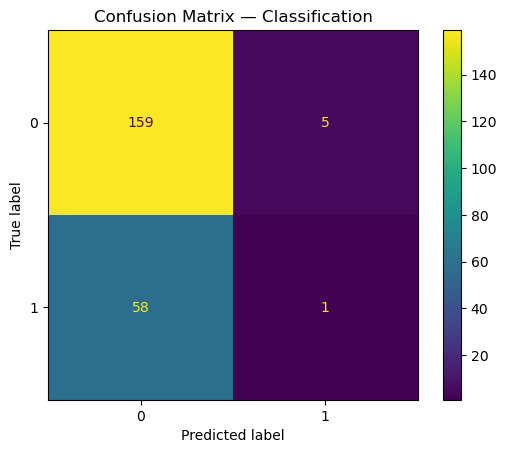

In [224]:
# 4.3 plot
fig = plt.figure()
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
plt.title("Confusion Matrix — Classification")
plt.show()


<a id="s05"></a>
## 05. Regression: Growth Rate Forecast

We predict **employment_change_pct_2023_2033** using a Random Forest with preprocessing:

- Numeric → median impute → scale  
- Categorical → most_frequent impute → one-hot

We’ll report **RMSE**, **MAE**, and **R²**.


In [227]:
# 5.1 Train + evaluate regression
# import numpy as np
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import OneHotEncoder, StandardScaler
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

target_reg = "employment_change_pct_2023_2033"

# Reuse feature_cols/num_cols/cat_cols, train_df/test_df from Section 03/04
regr_pre = ColumnTransformer([
    ("num", Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("scale", StandardScaler())
    ]), num_cols),
    ("cat", Pipeline([
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore"))
    ]), cat_cols),
])

regr = RandomForestRegressor(
    n_estimators=300,
    max_depth=10,
    random_state=42,
    n_jobs=-1,
)

regr_pipe = Pipeline([("pre", regr_pre), ("regr", regr_pipe := regr)])
regr_pipe.fit(train_df[feature_cols], train_df[target_reg])

y_true = test_df[target_reg].values
y_pred = regr_pipe.predict(test_df[feature_cols])

rmse = float(mean_squared_error(y_true, y_pred, squared=False))
mae  = float(mean_absolute_error(y_true, y_pred))
r2   = float(r2_score(y_true, y_pred))

regr_metrics = {
    "model_type": "RandomForestRegressor",
    "features_used": len(feature_cols),
    "hyperparams": "n_estimators=300, max_depth=10, seed=42; imputers: median/mode",
    "rmse": rmse,
    "mae": mae,
    "r2": r2,
}
regr_metrics


{'model_type': 'RandomForestRegressor',
 'features_used': 3,
 'hyperparams': 'n_estimators=300, max_depth=10, seed=42; imputers: median/mode',
 'rmse': 6.836041194005081,
 'mae': 4.9148283582902454,
 'r2': 0.06237614381515977}

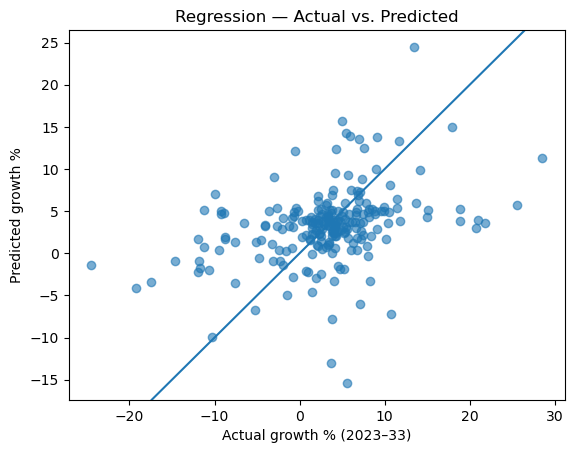

In [229]:
# 5.2 Quick scatter 

plt.figure()
plt.scatter(y_true, y_pred, alpha=0.6)
plt.xlabel("Actual growth % (2023–33)")
plt.ylabel("Predicted growth %")
plt.title("Regression — Actual vs. Predicted")
plt.axline((0,0), slope=1)  # 45° reference
plt.show()


<a id="s06"></a>
## 06. Findings & Recommendations

### 6.1 Executive Summary
Using BLS Table 1.2 (2023→2033) we built two baselines:

- **Classification (Emerging vs. Not)** — Logistic Regression on 3 features  
  **Accuracy:** 71.7% • **ROC AUC:** 0.636 • **PR AUC:** 0.369  
  **Precision:** 16.7% • **Recall:** 1.7% • **F1:** 3.1%  
  **Confusion Matrix:** [[TN=159, FP=5], [FN=58, TP=1]]

- **Regression (Growth % 2023→2033)** — Random Forest on the same 3 features  
  **R²:** 0.062 • **RMSE:** 6.84 p.p. • **MAE:** 4.91 p.p.

**Interpretation:** With BLS-only signals (2023 employment, 2024 median wage, occupation type), regression fit is modest and classification struggles to recover positives (very imbalanced “top-quartile” label). This is expected: predicting future growth from a tiny feature set is hard; adding richer skill/demand signals should materially improve recall and R².

---

### 6.2 What’s driving results (qualitative)
- **Median wage (2024)** loosely correlates with higher growth for some tech roles, but is not sufficient alone.
- **Occupation type (Summary vs Line item)** captures hierarchy, not skill mix; limited predictive power.
- **2023 employment level** helps anchor scale but not momentum.

---

### 6.3 Recommendations (3 concrete actions)
1. **Augment features with skills & demand signals.** Join WEF “rising skills” and Kaggle job-posting skill frequencies per SOC code. Add: % of postings mentioning AI/ML/cloud/cyber skills, salary bins, remote share, and trend deltas.  
2. **Rebalance the classifier for “emerging.”** Use class-weighting (`class_weight="balanced"`), tune the decision threshold to improve **recall** at acceptable precision, and/or test tree-based models (XGBoost/LightGBM) with calibrated probabilities.  
3. **Deliver a careers dashboard.** Ship a minimal dashboard that lists (a) **top-N projected growth roles**, (b) **skills gap** (current vs target skills), and (c) **learning paths** mapped to those skills. Use the model as ranking + evidence, not a sole decision-maker.

---

### 6.4 Risks & Limitations
- **Label definition:** “Emerging” = top quartile of growth; different cutoffs will change class balance/performance.
- **U.S. scope:** Results are U.S.-centric and may not generalize globally.
- **Data drift:** Skills demand and wages move quickly; plan a refresh cadence (e.g., quarterly).

---

### 6.5 Ideas for Further Research
- Add time-series trends from job postings (rolling 3–6–12 month skill momentum).
- Use SHAP/permutation importance to explain drivers.
- Try ordinal regression for growth buckets and cost-sensitive learning for rare emerging class.


<a id="s07"></a>
## 07. Export Final Artifacts

This step writes the required deliverables for submission:

- **Model_Metrics.csv** — a tidy, append-friendly log of final models with key metrics.
- **Model_Metrics.txt** — a short, human-readable “model card” summary for each model.
- **Model_Metrics.json** — raw metrics (same content as CSV/TXT) for programmatic use.

**Includes (per model):**
- *Classification:* model type, features used, hyperparameters, Accuracy, Precision, Recall, F1, ROC AUC, PR AUC, LogLoss, and Confusion Matrix.
- *Regression:* model type, features used, hyperparameters, R², RMSE, MAE.

**Output folder:** `outputs/`  
**Prerequisites:** run Sections **04** (classification) and **05** (regression) so `cls_metrics` and `regr_metrics` exist in memory.

> Tip: re-run this cell after any tuning to append a new row to `Model_Metrics.csv`.


In [235]:
import csv

# assumes cls_metrics and regr_metrics exist from 4.2 and 5.1 cells
assert isinstance(cls_metrics, dict), "cls_metrics not found. Run Section 4.2 first."
assert isinstance(regr_metrics, dict), "regr_metrics not found. Run Section 5.1 first."

os.makedirs("outputs", exist_ok=True)
csv_path = "outputs/Model_Metrics.csv"
txt_path  = "outputs/Model_Metrics.txt"
json_path = "outputs/Model_Metrics.json"

HEADER = ["timestamp","model_type","features_used","hyperparams",
          "accuracy","precision","recall","f1","roc_auc","pr_auc","log_loss",
          "rmse","mae","r2","notes"]

ts = datetime.datetime.now().isoformat(timespec="seconds")

# CSV append (creates with header if not exists)
exists = os.path.exists(csv_path)
with open(csv_path, "a", newline="") as f:
    w = csv.DictWriter(f, fieldnames=HEADER)
    if not exists:
        w.writeheader()
    # classification row
    w.writerow({
        "timestamp": ts,
        "model_type": cls_metrics.get("model_type"),
        "features_used": cls_metrics.get("features_used"),
        "hyperparams": cls_metrics.get("hyperparams"),
        "accuracy": cls_metrics.get("accuracy"),
        "precision": cls_metrics.get("precision"),
        "recall": cls_metrics.get("recall"),
        "f1": cls_metrics.get("f1"),
        "roc_auc": cls_metrics.get("roc_auc"),
        "pr_auc": cls_metrics.get("pr_auc"),
        "log_loss": cls_metrics.get("log_loss"),
        "notes": f"confusion={cls_metrics.get('confusion')}"
    })
    # regression row
    w.writerow({
        "timestamp": ts,
        "model_type": regr_metrics.get("model_type"),
        "features_used": regr_metrics.get("features_used"),
        "hyperparams": regr_metrics.get("hyperparams"),
        "rmse": regr_metrics.get("rmse"),
        "mae": regr_metrics.get("mae"),
        "r2": regr_metrics.get("r2"),
    })

# TXT: short model-card style summary with your actual numbers
with open(txt_path, "w") as tf:
    tf.write(
        "### Classification Model Card (Logistic Regression)\n"
        f"- Features: {cls_metrics.get('features_used')}\n"
        f"- Hyperparams: {cls_metrics.get('hyperparams')}\n"
        f"- Accuracy: {cls_metrics.get('accuracy'):.3f}\n"
        f"- ROC AUC: {cls_metrics.get('roc_auc'):.3f} | PR AUC: {cls_metrics.get('pr_auc'):.3f}\n"
        f"- Precision: {cls_metrics.get('precision'):.3f} | Recall: {cls_metrics.get('recall'):.3f} | F1: {cls_metrics.get('f1'):.3f}\n"
        f"- LogLoss: {cls_metrics.get('log_loss'):.3f}\n"
        f"- Confusion: {cls_metrics.get('confusion')}\n\n"
        "### Regression Model Card (RandomForestRegressor)\n"
        f"- Features: {regr_metrics.get('features_used')}\n"
        f"- Hyperparams: {regr_metrics.get('hyperparams')}\n"
        f"- R²: {regr_metrics.get('r2'):.3f} | RMSE: {regr_metrics.get('rmse'):.3f} | MAE: {regr_metrics.get('mae'):.3f}\n"
    )

# JSON: raw metrics
with open(json_path, "w") as jf:
    json.dump({"classification": cls_metrics, "regression": regr_metrics}, jf, indent=2)

print("Wrote:")
print(" -", csv_path)
print(" -", txt_path)
print(" -", json_path)


Wrote:
 - outputs/Model_Metrics.csv
 - outputs/Model_Metrics.txt
 - outputs/Model_Metrics.json


### Summary (Classification + Regression)

I trained two baseline models using BLS Table 1.2 features (2023 employment, 2024 median wage, occupation type).

- **Classification (Emerging vs. Not)** — Logistic Regression  
  **Accuracy:** 0.717 • **ROC AUC:** 0.636 • **PR AUC:** 0.369  
  **Precision:** 0.167 • **Recall:** 0.017 • **F1:** 0.031  
  **Confusion Matrix:** [[TN=159, FP=5], [FN=58, TP=1]]

- **Regression (Growth % 2023–33)** — Random Forest  
  **R²:** 0.062 • **RMSE:** 6.836 p.p. • **MAE:** 4.915 p.p.

With only BLS features, these serve as conservative baselines. The next priorities are to enrich features with skills/demand signals and rebalance/tune the classifier to improve recall while maintaining acceptable precision.


<a id="s08"></a>
## 08. Appendix

### 8.1 Data Dictionary (BLS Table 1.2 subset)
- `occupation_code` — 2023 National Employment Matrix code.
- `occupation_title` — Occupation name.
- `employment_2023` — Employment level in 2023 (thousands).
- `employment_2033` — Employment level in 2033 (thousands).
- `employment_change_pct_2023_2033` — Percent change between 2023 and 2033.
- `Occupation type` — “Summary” or “Line item”.
- `Median annual wage, dollars, 2024[1]` — 2024 median wage (USD).
- `is_emerging` — 1 if growth ≥ 75th percentile, else 0.

### 8.2 Modeling Notes
- **Classification:** Logistic Regression with median/mode imputation, scaling for numeric, OHE for categorical.
- **Regression:** RandomForestRegressor with the same preprocessing.
- **Train/Test:** 80/20 random split, seed=42.
- **Leakage Control:** All 2033 columns and targets excluded from features.

### 8.3 Limitations
- BLS-only features limit recall and R²; add skills/demand features next.
- “Emerging” defined via top-quartile growth → class imbalance.

### 8.4 Repro Steps
1. Run Sections 00 → 05 in order.  
2. Run Section 06 to insert summary.  
3. Run Section 07 to export metrics (CSV/TXT/JSON) to `outputs/`.
